In [1]:
import os
import warnings
import logging
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from glob import glob
import math
from numbers import Number

#sklearn - basic ML tools
from sklearn.metrics import roc_curve
from sklearn import metrics

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Conv3D, MaxPooling3D, BatchNormalization, Flatten, Dense, TimeDistributed, Dropout, GlobalAveragePooling1D
from tensorflow.keras import backend as K
from tensorflow.keras import Sequential, optimizers
from tensorflow.keras.callbacks import CSVLogger
from tensorflow.keras import utils, Input
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.train import BytesList, FloatList, Int64List
from tensorflow.train import Example, Features, Feature
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

#nilearn - neuroimaging tailored library
import nilearn
from nilearn import datasets
from nilearn import plotting
import nibabel as nib

from scipy import ndimage
from scipy.ndimage import zoom

warnings.filterwarnings("ignore")

2023-10-05 15:20:35.222521: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
gpu = tf.config.experimental.list_physical_devices('GPU')
print("GPU Available: ", gpu)

GPU Available:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


2023-10-03 20:58:26.554430: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-10-03 20:58:26.566820: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-10-03 20:58:26.569728: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [8]:
# Import preprocessed, ready-to-go, datasets
adhd_data=datasets.fetch_adhd(n_subjects=40, resume=False)
adhd_data.keys()

dict_keys(['func', 'confounds', 'phenotypic', 'description'])

### EDA

In [2]:
nilearn.datasets.get_data_dirs(data_dir=None)

['/home/jupyter/nilearn_data']

In [3]:
pd.set_option('display.max_columns', None)
pd.read_csv('/home/jupyter/nilearn_data/adhd/ADHD200_40subs_motion_parameters_and_phenotypics.csv', sep=',')

,Unnamed: 0,Subject,Rest.Scan,MeanFD,NumFD_greater_than_0.20,rootMeanSquareFD,FDquartile.top1.4thFD.,PercentFD_greater_than_0.20,MeanDVARS,MeanFD_Jenkinson,site,sibling_id,data_set,age,sex,handedness,full_2_iq,full_4_iq,viq,piq,iq_measure,tdc,adhd,adhd_inattentive,adhd_combined,adhd_subthreshold,diagnosis_using_cdis,notes,sess_1_anat_2,oppositional,cog_inatt,hyperac,anxious_shy,perfectionism,social_problems,psychosomatic,conn_adhd,restless_impulsive,emot_lability,conn_gi_tot,dsm_iv_inatt,dsm_iv_h_i,dsm_iv_tot,study,sess_1_rest_1,sess_1_rest_1_eyes,sess_1_rest_2,sess_1_rest_2_eyes,sess_1_rest_3,sess_1_rest_3_eyes,sess_1_rest_4,sess_1_rest_4_eyes,sess_1_rest_5,sess_1_rest_5_eyes,sess_1_rest_6,sess_1_rest_6_eyes,sess_1_anat_1,sess_1_which_anat,sess_2_rest_1,sess_2_rest_1_eyes,sess_2_rest_2,sess_2_rest_2_eyes,sess_2_anat_1,defacing_ok,defacing_notes
0,1,2014113,rest_1,0.0576,2,0.2400,0.0944,1.6000,16.1677,1.3868,KKI,NaN,data_set,10.345205,M,R,NaN,NaN,NaN,NaN,NaN,0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,pass,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,pass,NaN,NaN,NaN,NaN,NaN,NaN,yes,NaN
1,2,3902469,rest_1,0.0580,0,0.2409,0.0931,0.0000,17.4188,1.2040,KKI,NaN,data_set,10.635616,M,R,NaN,NaN,NaN,NaN,NaN,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,pass,closed,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,pass,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,4275075,rest_1,0.0789,0,0.2808,0.1520,0.0000,17.7796,1.8105,KKI,NaN,data_set,10.500000,F,R,NaN,NaN,NaN,NaN,NaN,0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,pass,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,pass,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,7774305,rest_1,0.0679,0,0.2606,0.1054,0.0000,16.7169,1.5137,KKI,NaN,data_set,11.220000,F,R,NaN,NaN,NaN,NaN,NaN,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,pass,closed,questionable,open,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,pass,NaN,NaN,NaN,NaN,NaN,NaN,yes,defaced part of front skull/brain
4,5,1019436,rest_1,0.0904,0,0.3006,0.1927,0.0000,19.6124,1.6769,KKI,NaN,data_set,12.980000,M,R,NaN,NaN,NaN,NaN,NaN,0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,pass,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,pass,NaN,NaN,NaN,NaN,NaN,NaN,yes,NaN
5,6,3699991,rest_1,0.1113,15,0.3337,0.2524,9.8039,19.8704,2.6121,KKI,4154182.0,data_set,12.772603,M,R,NaN,NaN,NaN,NaN,NaN,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,pass,closed,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,pass,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,7,3154996,rest_1,0.0881,0,0.2968,0.1619,0.0000,18.6120,1.8118,KKI,NaN,data_set,11.650000,M,R,NaN,NaN,NaN,NaN,NaN,0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,pass,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,8,3884955,rest_1,0.0988,8,0.3144,0.1881,6.4000,17.3609,1.9543,KKI,NaN,data_set,11.840000,M,R,NaN,NaN,NaN,NaN,NaN,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,pass,open,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,pass,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,9,27034,rest_1,0.0484,1,0.2201,0.0860,0.3831,21.5895,0.9262,NeuroImage,NaN,test_set,13.350000,M,R,97.0,NaN,NaN,NaN,5.0,0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,pass,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,pass,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,10,4134561,rest_1,0.0439,4,0.2095,0.0849,1.5267,25.0028,0.9207,NeuroImage,NaN,data_set,15.550000,M,NaN,NaN,NaN,NaN,NaN,NaN,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,pass,open,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,pass,NaN,NaN,NaN,NaN,NaN,NaN,yes,NaN


In [4]:
pd.read_csv('/home/jupyter/nilearn_data/adhd/ADHD200_40subs_slice_timing_parameters.csv', sep=',')

,Site,TR (seconds),Reference,Acquisition
0,Brown,2.00,17,alt+z
1,KKI,2.50,24,seq+z
2,NeuroImage,1.96,19,alt+z
3,NYU,2.00,17,alt+z
4,OHSU,2.50,18,alt+z2
5,Peking_1,2.00,17,alt+z
6,Peking_2,2.00,17,alt+z
7,Peking_3,2.00,15,alt+z2
8,Pittsburgh,1.50,15,alt+z
9,WashU,2.50,16,alt+z2


In [ ]:
ls /home/jupyter/nilearn_data/adhd 

In [5]:
with open("/home/jupyter/nilearn_data/adhd/ADHD200_40subs_ID.txt") as f: 
     print (f.read())

2014113
3902469
4275075
7774305
1019436
3699991
3154996
3884955
0027034
4134561
0027018
6115230
0027037
8409791
0027011
3007585
8697774
9750701
0010064
0021019
0010042
0010128
2497695
4164316
1552181
4046678
0023012
1679142
1206380
0023008
4016887
1418396
2950754
3994098
3520880
1517058
9744150
1562298
3205761
3624598



In [6]:
ls /home/jupyter/nilearn_data/adhd/data/7774305

7774305_regressors.csv                    7774305_rest_tshift_RPImasked.nii
7774305_rest_tshift_RPI_voreg_mni.nii.gz


In [9]:
adhd_data.phenotypic[0]['adhd']

1

In [10]:
adhd_data.confounds[0]

'/home/jupyter/nilearn_data/adhd/data/0010042/0010042_regressors.csv'

In [86]:
pd.read_csv(adhd_data.confounds[1], sep='\t')

,csf,constant,linearTrend,wm,global,motion-pitch,motion-roll,motion-yaw,motion-x,motion-y,motion-z,gm,compcor1,compcor2,compcor3,compcor4,compcor5
0,13343.032102,1.0,0.0,9486.199546,9921.655259,0.2691,0.0374,-0.0041,-0.0290,-0.0638,-0.0429,9540.217163,-0.029119,0.027238,-0.068965,0.053021,-0.079315
1,13329.224068,1.0,1.0,9497.003325,9925.703297,0.2492,0.0374,-0.0049,-0.0363,-0.0493,-0.0556,9547.195835,0.011274,-0.034316,-0.171048,0.069540,-0.072535
2,13291.755627,1.0,2.0,9484.012965,9895.596376,0.2371,0.0424,-0.0155,-0.0248,-0.0532,-0.0308,9524.844100,0.018361,0.013027,-0.032447,0.132613,-0.116010
3,13275.211268,1.0,3.0,9478.347686,9885.200123,0.2436,0.0353,-0.0031,-0.0263,-0.0566,-0.0348,9508.965221,-0.013877,-0.094640,0.018219,0.117555,-0.123433
4,13279.199963,1.0,4.0,9485.204640,9880.712964,0.2409,0.0362,-0.0185,-0.0281,-0.0588,-0.0323,9514.826901,0.024742,0.010994,-0.010686,0.068357,-0.059298
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
171,13404.753750,1.0,171.0,9637.143270,10087.887458,-0.2936,-0.0454,-0.0468,0.0067,0.1180,0.0204,9723.878198,-0.018102,0.144588,-0.022891,0.044318,0.043382
172,13443.144519,1.0,172.0,9639.132354,10096.289703,-0.2743,-0.0480,-0.0390,0.0208,0.1098,0.0158,9725.204707,-0.059910,0.020106,-0.043166,0.080873,-0.024700
173,13452.822209,1.0,173.0,9645.685284,10088.448834,-0.2953,-0.0399,-0.0320,0.0127,0.1055,0.0340,9714.818066,0.063437,-0.041775,-0.111803,0.114312,0.108542
174,13434.011000,1.0,174.0,9633.262418,10079.278830,-0.2804,-0.0392,-0.0428,0.0332,0.1166,0.0324,9710.930758,0.024752,0.030090,-0.046833,0.076331,0.042856


In [ ]:
func_filenames = adhd_data.func
confounds = adhd_data.confounds
phenotypic = adhd_data.phenotypic

In [88]:
print(adhd_data.description)

ADHD 200


Notes
-----
Part of the 1000 Functional Connectome Project. Phenotypic
information includes: diagnostic status, dimensional ADHD symptom measures,
age, sex, intelligence quotient (IQ) and lifetime medication status.
Preliminary quality control assessments (usable vs. questionable) based upon
visual timeseries inspection are included for all resting state fMRI scans.

Includes preprocessed data from 40 participants.

Project was coordinated by Michael P. Milham.

Content
-------
    :'func': Nifti images of the resting-state data
    :'phenotypic': Explanations of preprocessing steps
    :'confounds': CSV files containing the nuisance variables

References
----------
For more information about this dataset's structure:
http://fcon_1000.projects.nitrc.org/indi/adhd200/index.html

Licence: usage is unrestricted for non-commercial research purposes.



In [ ]:
nilearn.datasets.get_data_dirs(data_dir=phenotypic)

In [ ]:
# %load (func_filenames[0])
/home/jupyter/nilearn_data/adhd/data/0010042/0010042_rest_tshift_RPI_voreg_mni.nii.gz

In [29]:
IMAGE_PATH_LIST = glob('/home/jupyter/nilearn_data/adhd/data/*/*masked.nii')
#DATA = tf.data.Dataset.list_files(IMAGE_PATH_LIST)

#PHENO_PATH_LIST = glob('/home/jupyter/nilearn_data/adhd/data/*/*regressors.csv')
#PHENO = tf.data.Dataset.list_files(PHENO_PATH_LIST)

### Data Consumption

In [6]:
labels = []  # 1 if ADHD, 0 if control
img_label = []

for func_file, confound_file, phenotypic, mask in zip(
        adhd_data.func, adhd_data.confounds, adhd_data.phenotypic):
    
    labels.append(phenotypic['adhd'])
    img_label.append((func_file, phenotypic['adhd']))

### TFR Setup

In [7]:
def resize_image(img):
        FMRI_data = np.asanyarray(nib.load(img).dataobj)
        fmri_t = np.transpose(FMRI_data,axes=[3, 0, 1, 2])
        time_length= 77
        new_depth = 31
        new_width = 42
        new_height = 31
        old_depth = fmri_t.shape[1]
        old_width = fmri_t.shape[2]
        old_height = fmri_t.shape[3]
        ft = time_length/fmri_t.shape[0]
        fx = new_depth/old_depth
        fy = new_width/old_width
        fz = new_height/old_height
        fmri_resize = ndimage.zoom(fmri_t, (ft, fx,fy,fz) ,order=1)
        return fmri_resize[:,:,:,:]

In [11]:
# The following functions can be used to convert a value to a type compatible
# with tf.train.Example.

def _bytes_feature(value):
  """Returns a bytes_list from a string / byte."""
  if isinstance(value, type(tf.constant(0))):
    value = value.numpy() # BytesList won't unpack a string from an EagerTensor.
  return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

def _float_feature(value):
  """Returns a float_list from a float / double."""
  return tf.train.Feature(float_list=tf.train.FloatList(value=[value]))

def _int64_feature(value):
  """Returns an int64_list from a bool / enum / int / uint."""
  return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

def _fixup_shape(images, labels):
    images.set_shape([77, 31, 42, 31, 1])
    labels.set_shape([]) 
    return images, labels

def serialize_example(img: np.ndarray, label: Number) -> tf.train.Example:
    
    nii = resize_image(img)
    nii_serialized = tf.io.serialize_tensor(nii).numpy()
    
    feature = {
        't': _int64_feature(nii.shape[0]),
        'height': _int64_feature(nii.shape[1]),
        'width': _int64_feature(nii.shape[2]),
        'depth': _int64_feature(nii.shape[3]),
        'label': _float_feature(label),
        'image_raw': _bytes_feature(nii_serialized)
    }

    return tf.train.Example(features=tf.train.Features(feature=feature))


def write_records(niis, labels, n_per_record: int, outfile: str) -> None:
    """
    store list of niftis (and associated label) into tfrecords for use as dataset
    """
    n_niis = len(niis)
    n_records = math.ceil(len(niis) / n_per_record)

    for i, shard in enumerate(range(0, n_niis, n_per_record)):
        print(f"writing record {i} of {n_records-1}")
        with tf.io.TFRecordWriter(
                f"{outfile}_{i:0>3}-of-{n_records-1:0>3}.tfrecords", 
            options= tf.io.TFRecordOptions(compression_type="GZIP")
        ) as writer:
            for nii, label in zip(niis[shard:shard+n_per_record], labels[shard:shard+n_per_record]):
                example = serialize_example(img=nii, label=label)
                writer.write(example.SerializeToString())


def parse_1_example(example) -> tf.Tensor:
    X = tf.io.parse_tensor(example['image_raw'], out_type=tf.float32)
    return tf.expand_dims(X, -1), example['label']

def decode_example(record_bytes)-> dict:
    example = tf.io.parse_example(
        record_bytes,     
        features = {
            't':tf.io.FixedLenFeature([], tf.int64),
            'height': tf.io.FixedLenFeature([], tf.int64),
            'width': tf.io.FixedLenFeature([], tf.int64),
            'depth': tf.io.FixedLenFeature([], tf.int64),
            'label': tf.io.FixedLenFeature([], dtype=tf.float32),
            'image_raw': tf.io.FixedLenFeature([], dtype=tf.string)
          }
    )
    return example

def get_batched_dataset(files, batch_size: int = 4, shuffle_size: int=1024) -> tf.data.Dataset:
    dataset = (
        tf.data.Dataset.list_files(files) # note shuffling is on by default
        .flat_map(lambda x: tf.data.TFRecordDataset(x, compression_type="GZIP", num_parallel_reads=8))
        .map(decode_example, num_parallel_calls=tf.data.AUTOTUNE)
        .map(parse_1_example, num_parallel_calls=tf.data.AUTOTUNE)
        .map(_fixup_shape)
        .cache()  
        .shuffle(shuffle_size)
        .batch(batch_size, num_parallel_calls=tf.data.AUTOTUNE)
        .prefetch(tf.data.AUTOTUNE)
    )
    return dataset


### Generate Tensor Dataset

In [59]:
mni_nii = [item[0] for item in img_label]

labels = [item[1] for item in img_label]

In [83]:
len(mni_nii)

40

In [60]:
# store examples in each tfrecord. number of examples per record is configurable.
# aim for as many examples as produces files of size > 100M 
# 1 imge per file

write_records(mni_nii, labels, 1, "tmp")

writing record 0 of 39
writing record 1 of 39
writing record 2 of 39
writing record 3 of 39
writing record 4 of 39
writing record 5 of 39
writing record 6 of 39
writing record 7 of 39
writing record 8 of 39
writing record 9 of 39
writing record 10 of 39
writing record 11 of 39
writing record 12 of 39
writing record 13 of 39
writing record 14 of 39
writing record 15 of 39
writing record 16 of 39
writing record 17 of 39
writing record 18 of 39
writing record 19 of 39
writing record 20 of 39
writing record 21 of 39
writing record 22 of 39
writing record 23 of 39
writing record 24 of 39
writing record 25 of 39
writing record 26 of 39
writing record 27 of 39
writing record 28 of 39
writing record 29 of 39
writing record 30 of 39
writing record 31 of 39
writing record 32 of 39
writing record 33 of 39
writing record 34 of 39
writing record 35 of 39
writing record 36 of 39
writing record 37 of 39
writing record 38 of 39
writing record 39 of 39


In [14]:
# Get a list of all TFRecord files generated by write_records
n=40
tfrecord_files = [f"tmp_{i:0>3}-of-{n-1:0>3}.tfrecords" for i in range(n)]

# Read the records back.
list_of_records = tfrecord_files

In [15]:
list_of_train_records = list_of_records[:18]
list_of_validation_records = list_of_records[18:29]
list_of_test = list_of_records[29:]

In [16]:
# read the records back. this will be the list of files generated by write_records()
# a full dataset will have a list with many records
#list_of_records=['tmp_000-of-000.tfrecords']

#ds = get_batched_dataset(list_of_records, batch_size=5, shuffle_size=10)

train_ds = get_batched_dataset(list_of_train_records, batch_size=18, shuffle_size=10)
validation_ds = get_batched_dataset(list_of_validation_records, batch_size=12, shuffle_size=10)
test_ds = get_batched_dataset(list_of_test, batch_size=10, shuffle_size=10)

2023-10-05 17:04:06.134738: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-10-05 17:04:06.230043: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-10-05 17:04:06.233010: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [17]:
train_ds

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 77, 31, 42, 31, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.float32, name=None))>

### Check train, validation and test ds

In [17]:
train_ds_size = sum(1 for _ in train_ds)
validation_ds_size = sum(1 for _ in validation_ds)
test_ds_size = sum(1 for _ in test_ds)

train_ds_size, validation_ds_size, test_ds_size

(1, 1, 2)

In [28]:
# Check the shape of data batches from the training dataset
for batch in  train_ds.as_numpy_iterator():
    Xs, Ys = batch
    print(f"Xs shape: {Xs.shape}, Ys shape: {Ys.shape}")

Xs shape: (18, 77, 31, 42, 31, 1), Ys shape: (18,)


In [19]:
# Check the shape of data batches from the test dataset
for batch in validation_ds:
    Xs, Ys = batch
    print(f"Xs shape: {Xs.shape}, Ys shape: {Ys.shape}")

Xs shape: (11, 77, 31, 42, 31, 1), Ys shape: (11,)


In [20]:
# Check the shape of data batches from the test dataset
for batch in test_ds:
    Xs, Ys = batch
    print(f"Xs shape: {Xs.shape}, Ys shape: {Ys.shape}")

Xs shape: (10, 77, 31, 42, 31, 1), Ys shape: (10,)
Xs shape: (1, 77, 31, 42, 31, 1), Ys shape: (1,)


In [31]:
total_samples = sum(1 for _ in train_ds.as_numpy_iterator())
print("Total samples:", total_samples)

Total samples: 1


In [ ]:
# Iterate through the train_dataset and test_dataset to check their shapes
train_shapes = []
test_shapes = []

for example in train_ds:
    # Assuming each example in your dataset is a tuple (data, label)
    data, label = example
    train_shapes.append(data.shape)

for example in test_ds:
    data, label = example
    test_shapes.append(data.shape)

# Convert the shapes to a set to get unique shapes
unique_train_shapes = set(train_shapes)
unique_test_shapes = set(test_shapes)

print("Unique shapes in train_dataset:", unique_train_shapes)
print("Unique shapes in test_dataset:", unique_test_shapes)


In [21]:
# Iterate through the train_dataset to check for None dimensions in the data
for example in train_ds:
    data, label = example
    if None in data.shape.as_list():
        print("Found an example with a None dimension in the train_dataset.")
        break

### Model 

In [68]:
K.clear_session()

In [69]:
# Specify shape of convolution kernel
kernel_size = (3, 3, 3)

# Specify number of output categories
n_classes = 2

# Specify number of filters per layer
filters = 8  


In [70]:
input = keras.Input(shape=(77, 31, 42, 31, 1), name="original_img")
x = TimeDistributed(Conv3D(filters, kernel_size, activation='relu', strides=(3, 3, 2)))(input)
x = TimeDistributed(MaxPooling3D())(x)
x = TimeDistributed(BatchNormalization())(x)

x = TimeDistributed((Conv3D(filters * 2, kernel_size, activation='relu')))(x)
x = TimeDistributed(MaxPooling3D(pool_size=(2, 2, 1)))(x)
x = TimeDistributed(BatchNormalization())(x)

x= TimeDistributed(Flatten())(x)
x= GlobalAveragePooling1D()(x)
x= Dropout(0.5)(x)

output = Dense(units=1, activation="relu")(x)

model = keras.Model(input, output, name="encoder")

model.summary()

Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 original_img (InputLayer)   [(None, 77, 31, 42, 31,   0         
                              1)]                                
                                                                 
 time_distributed (TimeDist  (None, 77, 10, 14, 15,    224       
 ributed)                    8)                                  
                                                                 
 time_distributed_1 (TimeDi  (None, 77, 5, 7, 7, 8)    0         
 stributed)                                                      
                                                                 
 time_distributed_2 (TimeDi  (None, 77, 5, 7, 7, 8)    32        
 stributed)                                                      
                                                                 
 time_distributed_3 (TimeDi  (None, 77, 3, 5, 5, 16)   3472

In [71]:
# Compile model.
initial_learning_rate = 0.0001
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=100000, decay_rate=0.96, staircase=True
)

model.compile(
    loss="binary_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate=lr_schedule),
    metrics=["BinaryAccuracy"],
)


In [72]:
# Train the model, doing validation at the end of each epoch
epochs = 50
history = model.fit(
    train_ds,
    validation_data=(validation_ds),
    epochs=epochs,
    verbose=2
)

Epoch 1/50


2023-10-03 21:15:24.867524: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous recv item cancelled. Key hash: 1518335286597489091
2023-10-03 21:15:24.867658: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous recv item cancelled. Key hash: 14551565898974008707


1/1 - 3s - loss: 8.9684 - binary_accuracy: 0.3125 - val_loss: 9.9679 - val_binary_accuracy: 0.2727 - 3s/epoch - 3s/step
Epoch 2/50


2023-10-03 21:15:25.164124: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous recv item cancelled. Key hash: 14551565898974008707
2023-10-03 21:15:25.164207: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous recv item cancelled. Key hash: 12287620522318462290


1/1 - 0s - loss: 5.8237 - binary_accuracy: 0.5625 - val_loss: 9.9993 - val_binary_accuracy: 0.2727 - 304ms/epoch - 304ms/step
Epoch 3/50
1/1 - 0s - loss: 7.8800 - binary_accuracy: 0.3750 - val_loss: 8.9017 - val_binary_accuracy: 0.2727 - 303ms/epoch - 303ms/step
Epoch 4/50
1/1 - 0s - loss: 8.7522 - binary_accuracy: 0.3750 - val_loss: 8.7612 - val_binary_accuracy: 0.2727 - 304ms/epoch - 304ms/step
Epoch 5/50
1/1 - 0s - loss: 7.7877 - binary_accuracy: 0.4375 - val_loss: 8.7132 - val_binary_accuracy: 0.2727 - 302ms/epoch - 302ms/step
Epoch 6/50
1/1 - 0s - loss: 7.2966 - binary_accuracy: 0.3750 - val_loss: 8.7372 - val_binary_accuracy: 0.2727 - 302ms/epoch - 302ms/step
Epoch 7/50
1/1 - 0s - loss: 5.2917 - binary_accuracy: 0.4375 - val_loss: 8.9532 - val_binary_accuracy: 0.2727 - 303ms/epoch - 303ms/step
Epoch 8/50
1/1 - 0s - loss: 5.1147 - binary_accuracy: 0.5625 - val_loss: 9.8533 - val_binary_accuracy: 0.3636 - 302ms/epoch - 302ms/step
Epoch 9/50
1/1 - 0s - loss: 8.9072 - binary_accuracy

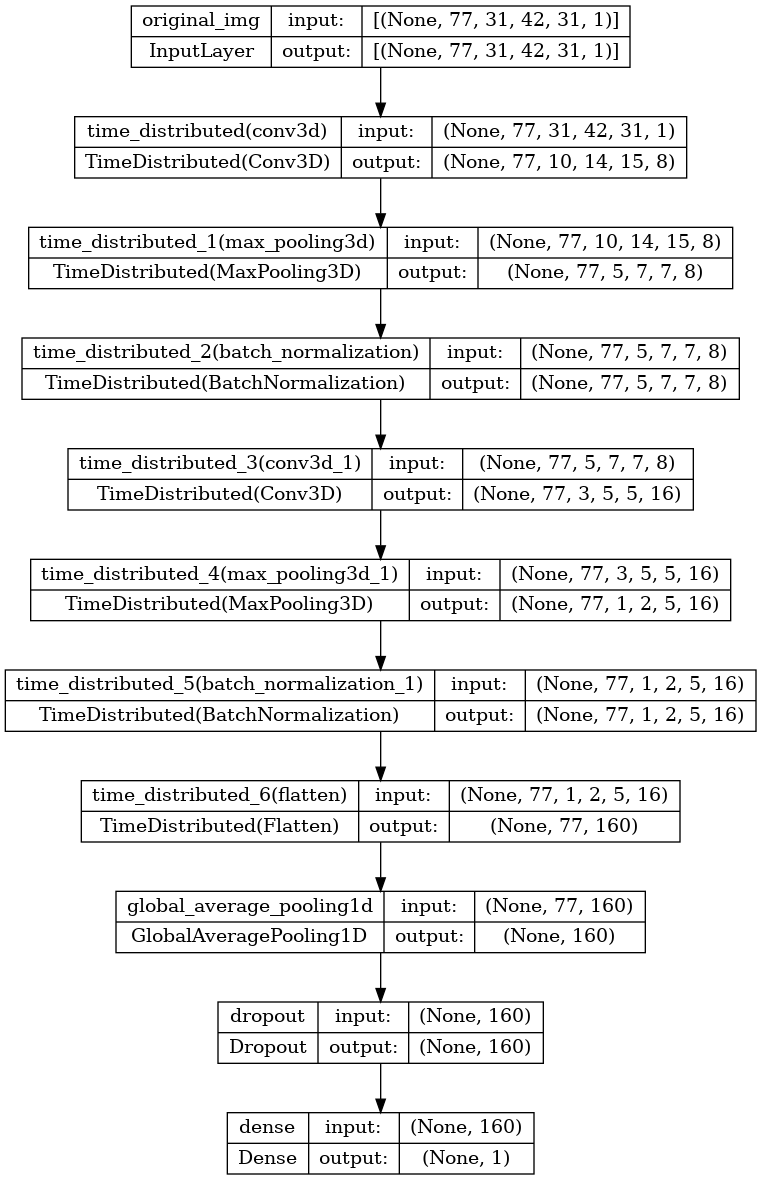

In [22]:
plot_model(model, show_shapes=True, show_layer_names=True)

In [23]:
print("Number of weights after calling the model:", len(model.weights))

Number of weights after calling the model: 14


In [73]:
evaluation = model.evaluate(test_ds)

2/2 [==============================] - 0s 31ms/step - loss: 1.5944 - binary_accuracy: 0.7692


2023-10-03 21:15:49.846466: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous recv item cancelled. Key hash: 14551565898974008707
2023-10-03 21:15:49.846519: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous recv item cancelled. Key hash: 12287620522318462290


In [74]:
print('Loss in Test set:      %.02f' % (evaluation[0]))
print('Accuracy in Test set:  %.02f' % (evaluation[1] * 100))

Loss in Test set:      1.59
Accuracy in Test set:  76.92


In [80]:
model.metrics_names

['loss', 'binary_accuracy']

In [81]:
model.save_weights('tmp2') 

In [82]:
model.save('tmp2')

INFO:tensorflow:Assets written to: tmp2/assets


INFO:tensorflow:Assets written to: tmp2/assets


In [ ]:
# Check the number of data points in your dataset
num_data_points = 0

for batch in train_ds:
    num_data_points += batch[0].shape[0]
    
print("Number of data points:", num_data_points)

# Specify the number of epochs
num_epochs = 100  # Adjust as needed

# Specify the batch size
batch_size = 20  # Adjust as needed

# Calculate the expected number of iterations
expected_iterations = (num_data_points + batch_size - 1) // batch_size * num_epochs


In [ ]:
# Train the model
model.fit(train_ds, epochs=num_epochs, batch_size=batch_size)

# Check the actual number of iterations
actual_iterations = model.history.epoch[-1] + 1

# Compare the expected and actual number of iterations
if actual_iterations >= expected_iterations:
    print("The model used all the data during training.")
else:
    print("The model did not use all the data during training.")

In [77]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [78]:
for batch in test_ds.as_numpy_iterator(): 
    X, y = batch
    yhat = model.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)

1/1 [==============================] - 0s 32ms/step


In [79]:
print(pre.result(), re.result(), acc.result())

tf.Tensor(1.0, shape=(), dtype=float32) tf.Tensor(0.25, shape=(), dtype=float32) tf.Tensor(0.7692308, shape=(), dtype=float32)
